# DonorsChoose

In [80]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import random
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import math
from tqdm import tqdm
import os
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from prettytable import PrettyTable
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 1.1 Reading Data

In [ ]:
# ##colab
# # Run this cell and select the kaggle.json file downloaded
# # from the Kaggle account settings page.
# from google.colab import files
# files.upload()

In [ ]:
# !pip install -q kaggle
# # The Kaggle API client expects this file to be in ~/.kaggle,
# # so move it there.
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# # This permissions change avoids a warning on Kaggle tool startup.
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d atifimam/donors-chose
# !unzip /content/donors-chose.zip

train_data="/content/train_data.csv"
resources="/content/resources.csv"
glove_vectors="/content/glove_vectors"

In [ ]:
##kaggle
# train_data="/kaggle/input/donors-chose/train_data.csv"
# resources="/kaggle/input/donors-chose/resources.csv"
# glove_vectors="/kaggle/input/donors-chose/glove_vectors"

In [ ]:
# ##oakwood
# train_data="../Donor Choose/train_data.csv"
# resources="../Donor Choose/resources.csv"
# glove_vectors="../Donor Choose/glove_vectors"

In [ ]:
project_data = pd.read_csv(train_data, nrows=50000)
resource_data = pd.read_csv(resources)

In [86]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (50000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [87]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


### 1.1 Checking for missing values

In [88]:
# check for missing values in python : https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b
print (project_data.isnull().sum())

Unnamed: 0                                          0
id                                                  0
teacher_id                                          0
teacher_prefix                                      2
school_state                                        0
project_submitted_datetime                          0
project_grade_category                              0
project_subject_categories                          0
project_subject_subcategories                       0
project_title                                       0
project_essay_1                                     0
project_essay_2                                     0
project_essay_3                                 48315
project_essay_4                                 48315
project_resource_summary                            0
teacher_number_of_previously_posted_projects        0
project_is_approved                                 0
dtype: int64


The above output shows that there are missing values in teacher prefix, project_essay_3 and project_essay_4. We can drop the 3 rows having missing teacher prefix. From the description of the project, we know that the numbers of essay submissions were reduced to 2 from 4. So the can ignore the rows having missing project_essay_3 and project_essay_4 as its expected.



In [ ]:
# dropna column pandas :https://stackoverflow.com/a/23235618/8363466
project_data = project_data[pd.notnull(project_data['teacher_prefix'])]

In [90]:
# check for missing values in python : https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b
print (project_data.isnull().sum())

Unnamed: 0                                          0
id                                                  0
teacher_id                                          0
teacher_prefix                                      0
school_state                                        0
project_submitted_datetime                          0
project_grade_category                              0
project_subject_categories                          0
project_subject_subcategories                       0
project_title                                       0
project_essay_1                                     0
project_essay_2                                     0
project_essay_3                                 48314
project_essay_4                                 48314
project_resource_summary                            0
teacher_number_of_previously_posted_projects        0
project_is_approved                                 0
dtype: int64


## 1.2 preprocessing of `project_subject_categories`

In [ ]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [ ]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.4 Text preprocessing

In [ ]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [94]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...


In [ ]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
# Combining all the above stundents 
def preprocessTextData(dataToProcess):
    """This function do the preprocessing of the column text data in essay and title"""
    processedData = []
    # tqdm is for printing the status bar
    for sentance in tqdm(dataToProcess):
        #convert the sentence to lower case before decontracting
        lowersent = sentance.lower()
        sent = decontracted(lowersent)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        processedData.append(sent.strip())
    return processedData


In [98]:
project_data['project_grade_category'] =  project_data['project_grade_category'].str.replace(" ", "_")
project_data['project_grade_category'] =  project_data['project_grade_category'].str.replace("-", "_")
project_data['project_grade_category'].value_counts()

Grades_PreK_2    20316
Grades_3_5       16967
Grades_6_8        7750
Grades_9_12       4965
Name: project_grade_category, dtype: int64

## 1.5 Preparing data for models

In [99]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.5.1 Vectorizing Categorical data

In [ ]:
#fitting categorical data
def fitCatogarizedData(dataToProcess, vocab = None):
    if vocab is None :
        vectorizer = CountVectorizer()
    else:
        vectorizer = CountVectorizer(vocabulary=vocab, lowercase=False, binary=True)
    vectorizer.fit(dataToProcess)
    return vectorizer

#transforming categorical data
def transformCatogarizedData(dataToProcess, vectorizer):
    categories_one_hot = vectorizer.fit_transform(dataToProcess.values)
    print(vectorizer.get_feature_names())
    print("Shape of matrix after one hot encodig ",categories_one_hot.shape)
    return categories_one_hot

### 1.5.2 Vectorizing Text data

#### 1.5.2.1 Bag of words

In [ ]:
#fitting bag of words
def fitBow(textToProcess):
    # We are considering only the words which appeared in at least 10 documents(rows or projects).
    vectorizer = CountVectorizer(min_df=10, ngram_range=(1, 2), max_features=5000)
    vectorizer.fit(textToProcess)
    return vectorizer
#transforming bag of words
def transformBow(textToProcess, vectorizer):
    processedText = vectorizer.transform(textToProcess)
    print("Shape of matrix after one hot encodig ",processedText.shape)
    return processedText

#### 1.5.2.2 TFIDF vectorizer

In [ ]:
#fitting tfidf 
def fitTfidf(textToProcess):
    # We are considering only the words which appeared in at least 10 documents(rows or projects).
    vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2), max_features=5000)
    processedText = vectorizer.fit(textToProcess)
    return vectorizer
#transforming tfidf
def transformTfidf(textToProcess, vectorizer):
    processedText = vectorizer.transform(textToProcess)
    print("Shape of matrix after one hot encodig ",processedText.shape)
    return processedText

#### 1.5.2.3 Using Pretrained Models: Avg W2V

In [ ]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open(glove_vectors, 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
def fitAvgW2V(dataToProcess):
    avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(dataToProcess): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)

    print(len(avg_w2v_vectors))
    print(len(avg_w2v_vectors[0]))
    return avg_w2v_vectors

#### 1.5.2.3 Using Pretrained Models: TFIDF weighted W2V

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
def fitTfidfw2v(textToProcess):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(textToProcess)
    return tfidf_model

In [ ]:
# tfidf Word2Vec
# compute tfidf word2vec for each review.
def transformTfidfw2v(textToProcess, vectorizer):
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
    tfidf_words = set(vectorizer.get_feature_names())
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(textToProcess): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)

    print(len(tfidf_w2v_vectors))
    print(len(tfidf_w2v_vectors[0]))
    return tfidf_w2v_vectors

### 1.5.3 Vectorizing Numerical features

In [ ]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [ ]:
#Minmax Scalar sklearn : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
#Minmax scalar is used as we need the scaled values to be positive for selectKbest to use chi2
#fitting numerical data
def fitNumerical(dataToProcess):
    numerical_scalar = MinMaxScaler()
    numerical_scalar.fit(dataToProcess)
    return numerical_scalar
#transforming numerical data
def transformNumerical(DataToprocess, scalar):
    return scalar.transform(DataToprocess)

<h1>2. Logistic Regression </h1>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [109]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)
X.head(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
print("Size of X_train ", X_train.shape)
print("Size of X_train ", X_test.shape)
print("Size of X_train ", y_train.shape)
print("Size of X_train ", y_test.shape)

Size of X_train  (33498, 19)
Size of X_train  (16500, 19)
Size of X_train  (33498,)
Size of X_train  (16500,)


<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [110]:
#Encoding price data    
price_vector = fitNumerical(X_train['price'].values.reshape(-1,1))
price_train = transformNumerical(X_train['price'].values.reshape(-1,1), price_vector)
price_test = transformNumerical(X_test['price'].values.reshape(-1,1), price_vector)

#Encoding quantity data
quantity_vector = fitNumerical(X_train['price'].values.reshape(-1,1))
quantity_train = transformNumerical(X_train['price'].values.reshape(-1,1), quantity_vector)
quantity_test = transformNumerical(X_test['price'].values.reshape(-1,1), quantity_vector)

#Encoding teacher_previously_posted_projects data
previous_projects_vector = fitNumerical(X_train['price'].values.reshape(-1,1))
previous_projects_train = transformNumerical(X_train['price'].values.reshape(-1,1), previous_projects_vector)
previous_projects_test = transformNumerical(X_test['price'].values.reshape(-1,1), previous_projects_vector)

#one hot encoding of clean categories
catagories_vector = fitCatogarizedData(X_train['clean_categories'], list(sorted_cat_dict.keys()))
catagories_train = transformCatogarizedData(X_train['clean_categories'], catagories_vector)
catagories_test = transformCatogarizedData(X_test['clean_categories'], catagories_vector)

#one hot encoding of clean sub categories
sub_catagories_vector = fitCatogarizedData(X_train['clean_subcategories'], list(sorted_sub_cat_dict.keys()))
sub_catagories_train = transformCatogarizedData(X_train['clean_subcategories'], sub_catagories_vector)
sub_catagories_test = transformCatogarizedData(X_test['clean_subcategories'], sub_catagories_vector)

#one hot encoding of project grade categories
project_grade_vector = fitCatogarizedData(X_train["project_grade_category"])
project_grade_train = transformCatogarizedData(X_train['project_grade_category'], project_grade_vector)
project_grade_test = transformCatogarizedData(X_test['project_grade_category'], project_grade_vector)

#one hot encoding of states
state_vector = fitCatogarizedData(X_train['school_state'])
state_train = transformCatogarizedData(X_train['school_state'], state_vector)
state_test = transformCatogarizedData(X_test['school_state'], state_vector)

#one hot encoding of teacher prefix
teacher_prefix_vector = fitCatogarizedData(X_train['teacher_prefix'])
teacher_prefix_train = transformCatogarizedData(X_train['teacher_prefix'], teacher_prefix_vector)
teacher_prefix_test = transformCatogarizedData(X_test['teacher_prefix'], teacher_prefix_vector)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (33498, 9)
['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (16500, 9)
['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (33498, 30)
['Economics', 'CommunityService', 

<h2>2.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [111]:
#preprocessing essays
essay_train = preprocessTextData(X_train['essay'].values)
essay_test = preprocessTextData(X_test['essay'].values)

#preprocessing titles
title_train = preprocessTextData(X_train['project_title'].values)
title_test = preprocessTextData(X_test['project_title'].values)

100%|██████████| 16500/16500 [00:00<00:00, 43242.71it/s]


In [112]:
#creating bow essay and title vectors
essay_bow_vector = fitBow(essay_train)
bow_essay_train = transformBow(essay_train, essay_bow_vector)
bow_essay_test = transformBow(essay_test, essay_bow_vector)

title_bow_vector = fitBow(title_train)
bow_title_train = transformBow(title_train, title_bow_vector)
bow_title_test = transformBow(title_test, title_bow_vector)

Shape of matrix after one hot encodig  (33498, 5000)
Shape of matrix after one hot encodig  (16500, 5000)
Shape of matrix after one hot encodig  (33498, 2314)
Shape of matrix after one hot encodig  (16500, 2314)


In [113]:
#creating tfidf essay and title vectors
essay_tfidf_vector = fitTfidf(essay_train)
tfidf_essay_train = transformTfidf(essay_train, essay_tfidf_vector)
tfidf_essay_test = transformTfidf(essay_test, essay_tfidf_vector)

title_tfidf_vector = fitTfidf(title_train)
tfidf_title_train = transformTfidf(title_train, title_tfidf_vector)
tfidf_title_test = transformTfidf(title_test, title_tfidf_vector)

Shape of matrix after one hot encodig  (33498, 5000)
Shape of matrix after one hot encodig  (16500, 5000)
Shape of matrix after one hot encodig  (33498, 2314)
Shape of matrix after one hot encodig  (16500, 2314)


In [114]:
#creating avgw2v essay and title vectors
avgw2v_essay_train = fitAvgW2V(essay_train)
avgw2v_essay_test = fitAvgW2V(essay_test)
avgw2v_title_train = fitAvgW2V(title_train)
avgw2v_title_test = fitAvgW2V(title_test)

  0%|          | 0/16500 [00:00<?, ?it/s]

33498
300


 22%|██▏       | 7498/33498 [00:00<00:00, 74971.31it/s]

16500
300


 46%|████▌     | 7515/16500 [00:00<00:00, 75148.10it/s]

33498
300


100%|██████████| 16500/16500 [00:00<00:00, 72357.02it/s]


16500
300


In [115]:
#creating tfidfw2v essay and title vectors
essay_tfidfw2v_vector = fitTfidfw2v(essay_train)
tfidfw2v_essay_train = transformTfidfw2v(essay_train, essay_tfidfw2v_vector)
tfidfw2v_essay_test = transformTfidfw2v(essay_test, essay_tfidfw2v_vector)
title_tfidfw2v_vector = fitTfidfw2v(title_train)
tfidfw2v_title_train = transformTfidfw2v(title_train, title_tfidfw2v_vector)
tfidfw2v_title_test = transformTfidfw2v(title_test, title_tfidfw2v_vector)

100%|██████████| 33498/33498 [00:57<00:00, 580.27it/s]


33498
300


100%|██████████| 16500/16500 [00:28<00:00, 586.78it/s]


16500
300


100%|██████████| 33498/33498 [00:00<00:00, 33951.12it/s]


33498
300


100%|██████████| 16500/16500 [00:00<00:00, 39979.40it/s]


16500
300


<h2>2.4 Appling Logistic Regression on different kind of featurization as mentioned in the instructions</h2>

<br>Apply Logistic Regression on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [ ]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [ ]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
#function to do randomized search cross validation
def doGridSearch(X_tr, y_train):
    lr = LogisticRegression(class_weight='balanced', n_jobs=-1)

    parameters = {'C':[0.001, 0.003, 0.01, 0.03, 0.1, 0.5, 0.8, 1, 3, 10,  30, 100, 300]}

    clf = GridSearchCV(lr, parameters, cv= 10, scoring='roc_auc',return_train_score=True, n_jobs=-1)

    clf.fit(X_tr, y_train)

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    alphas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.5, 0.8, 1, 3, 10,  30, 100, 300]
    log_alphas =[np.log(x) for x in alphas]



    plt.figure(figsize=(20,10))

    plt.plot(log_alphas, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(log_alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

    plt.plot(log_alphas, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(log_alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

    plt.scatter(log_alphas, train_auc, label='Train AUC points')
    plt.scatter(log_alphas, cv_auc, label='CV AUC points')


    plt.legend()
    plt.xlabel("alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title("alpha: hyperparameter v/s AUC")
    plt.grid(color='black', linestyle='-', linewidth=0.5)
    plt.show()
    return clf

In [ ]:
#function to plot auc and heat maps of confusion matrix
def plotAucAndHeatmap(C, X_tr, X_te, y_train, y_test):
    lr = LogisticRegression(C=C, class_weight='balanced', n_jobs=-1)
    lr.fit(X_tr, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_train_pred = batch_predict(lr, X_tr)    
    y_test_pred = batch_predict(lr, X_te)
    
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ERROR PLOTS")
    plt.grid()
    plt.show()
    
    print("="*100)
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
    print("="*100)
    
    
    plotheatMap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
    return str(auc(train_fpr, train_tpr)), str(auc(test_fpr, test_tpr))

In [ ]:
# subplot seaborn : https://stackoverflow.com/a/41384984/8363466
#confusion matrix heat map : https://seaborn.pydata.org/generated/seaborn.heatmap.html
#plot confusion matrix of test and train
def plotheatMap(confusion_matrix_train, confusion_matrix_test):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    
    confusion_train_bow = pd.DataFrame(confusion_matrix_train)
    sns.heatmap(confusion_train_bow, annot=True, fmt='d', ax=ax1)
    ax1.set_title("Train Confusion matrix")
    ax1.set(xlabel='Actual', ylabel='Predicted')
    
    confusion_test_bow = pd.DataFrame(confusion_matrix_test)
    sns.heatmap(confusion_test_bow, annot=True, fmt='d', ax=ax2)
    ax2.set_title("Test Confusion matrix")
    ax2.set(xlabel='Actual', ylabel='Predicted')

In [ ]:
#function to analyse the sentimence
def sentimenceOfEssay(preprocessedEssay):
    neg = []
    neu = []
    pos = [] 
    com = []
    sid = SentimentIntensityAnalyzer()
    for essay in tqdm(preprocessedEssay):
        sent = sid.polarity_scores(essay)
        neg.append(sent['neg'])
        neu.append(sent['neu'])
        pos.append(sent['pos'])
        com.append(sent['compound'])
        negative = np.reshape(np.asarray(neg), (-1,1))
        neutral = np.reshape(np.asarray(neu), (-1,1))
        positive = np.reshape(np.asarray(pos), (-1,1))
        compound = np.reshape(np.asarray(com), (-1,1))
    return negative, neutral, positive, compound

In [ ]:
#function to count words in essay and title
def countWords(data):
    word_count = []
    for essay in tqdm(data):
        word_count.append(len(essay.split()))
    return word_count

### 2.4.1 Applying Logistic Regression on BOW,<font color='red'> SET 1</font>

In [123]:
#creating train and test data for naive bayes on BOW
X_tr = hstack((price_train, quantity_train, previous_projects_train, catagories_train, sub_catagories_train, project_grade_train, state_train, teacher_prefix_train, bow_essay_train, bow_title_train)).tocsr()
X_te = hstack((price_test, quantity_test, previous_projects_test, catagories_test, sub_catagories_test, project_grade_test, state_test, teacher_prefix_test, bow_essay_test, bow_title_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33498, 7416) (33498,)
(16500, 7416) (16500,)


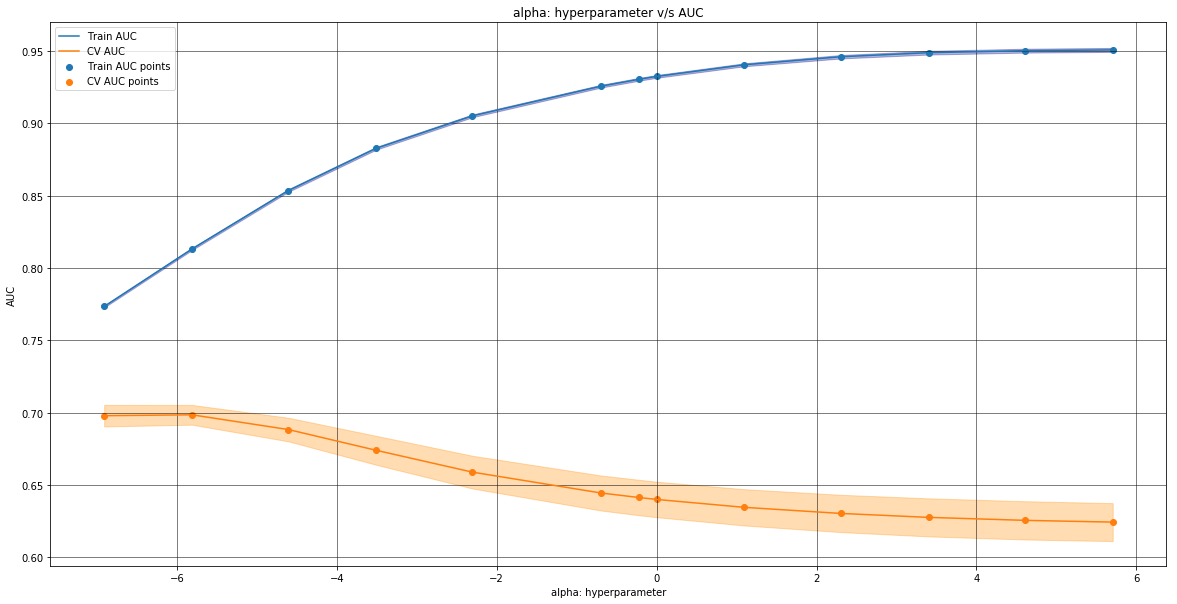

CPU times: user 3.6 s, sys: 459 ms, total: 4.06 s
Wall time: 38min 35s


In [124]:
%%time
#doing grid search to find best lambda
bow_clf = doGridSearch(X_tr, y_train)

In [125]:
#randomizedsearchcv sklearn: https://www.youtube.com/watch?v=Gol_qOgRqfA
print(bow_clf.best_score_)
print(bow_clf.best_params_)

0.6984871233411909
{'C': 0.003}


In [126]:
print("Value of lambda is ",1/bow_clf.best_params_['C'])

Value of lambda is  333.3333333333333


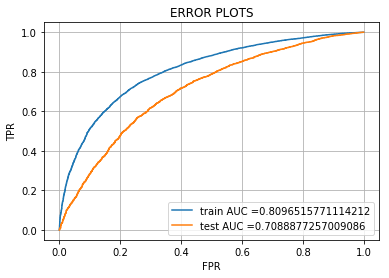

the maximum value of tpr*(1-fpr) 0.5484931367813441 for threshold 0.489
Train confusion matrix
[[ 3837  1331]
 [ 7401 20929]]
Test confusion matrix
[[1536 1010]
 [3987 9967]]


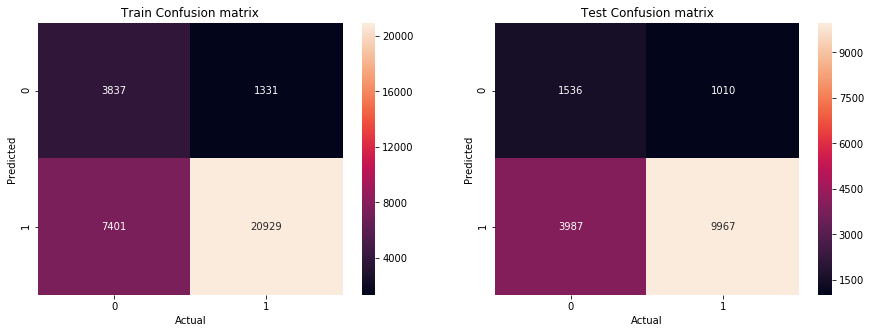

In [127]:
#plotting auc and confusion matrix
bow_train_auc, bow_test_auc = plotAucAndHeatmap(bow_clf.best_params_['C'], X_tr, X_te, y_train, y_test)

### 2.4.1 Applying Logistic Regression on TFIDF,<font color='red'> SET 2</font>

In [128]:
#creating train and test data for naive bayes on BOW
X_tr = hstack((price_train, quantity_train, previous_projects_train, catagories_train, sub_catagories_train, project_grade_train, state_train, teacher_prefix_train, tfidf_essay_train, tfidf_title_train)).tocsr()
X_te = hstack((price_test, quantity_test, previous_projects_test, catagories_test, sub_catagories_test, project_grade_test, state_test, teacher_prefix_test, tfidf_essay_test, tfidf_title_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33498, 7416) (33498,)
(16500, 7416) (16500,)


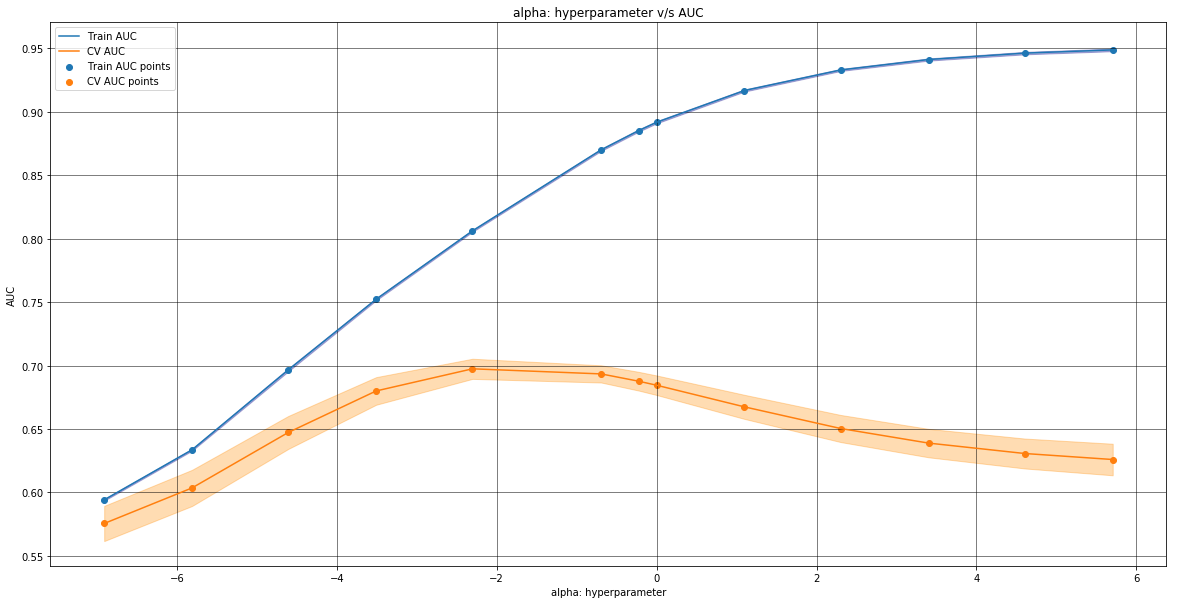

CPU times: user 4.48 s, sys: 301 ms, total: 4.78 s
Wall time: 15min 19s


In [129]:
%%time
#doing grid search to find best lambda
tfidf_clf = doGridSearch(X_tr, y_train)

In [130]:
#randomizedsearchcv sklearn: https://www.youtube.com/watch?v=Gol_qOgRqfA
print(tfidf_clf.best_score_)
print(tfidf_clf.best_params_)

0.6974428192937349
{'C': 0.1}


In [131]:
print("Value of lambda is ",1/tfidf_clf.best_params_['C'])

Value of lambda is  10.0


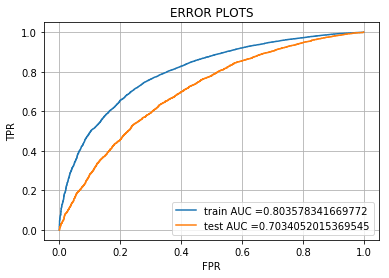

the maximum value of tpr*(1-fpr) 0.5383264767627005 for threshold 0.488
Train confusion matrix
[[ 3726  1442]
 [ 7177 21153]]
Test confusion matrix
[[ 1462  1084]
 [ 3864 10090]]


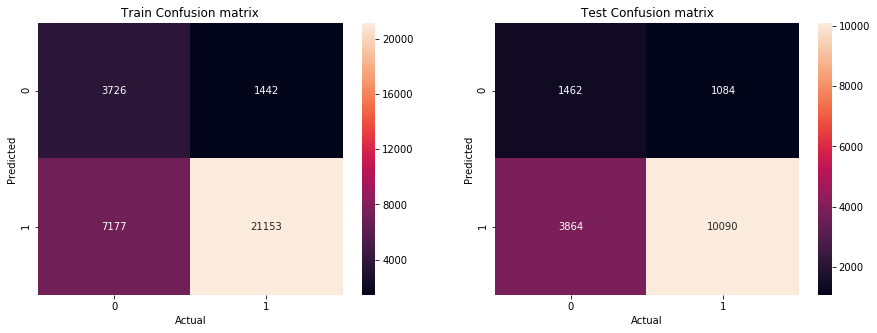

In [132]:
#plotting auc and confusion matrix
tfidf_train_auc, tfidf_test_auc = plotAucAndHeatmap(tfidf_clf.best_params_['C'], X_tr, X_te, y_train, y_test)

### 2.4.1 Applying Logistic Regression on AVGW2V,<font color='red'> SET 3</font>

In [133]:
#creating train and test data for naive bayes on BOW
X_tr = hstack((price_train, quantity_train, previous_projects_train, catagories_train, sub_catagories_train, project_grade_train, state_train, teacher_prefix_train, avgw2v_essay_train, avgw2v_title_train)).tocsr()
X_te = hstack((price_test, quantity_test, previous_projects_test, catagories_test, sub_catagories_test, project_grade_test, state_test, teacher_prefix_test, avgw2v_essay_test, avgw2v_title_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33498, 702) (33498,)
(16500, 702) (16500,)


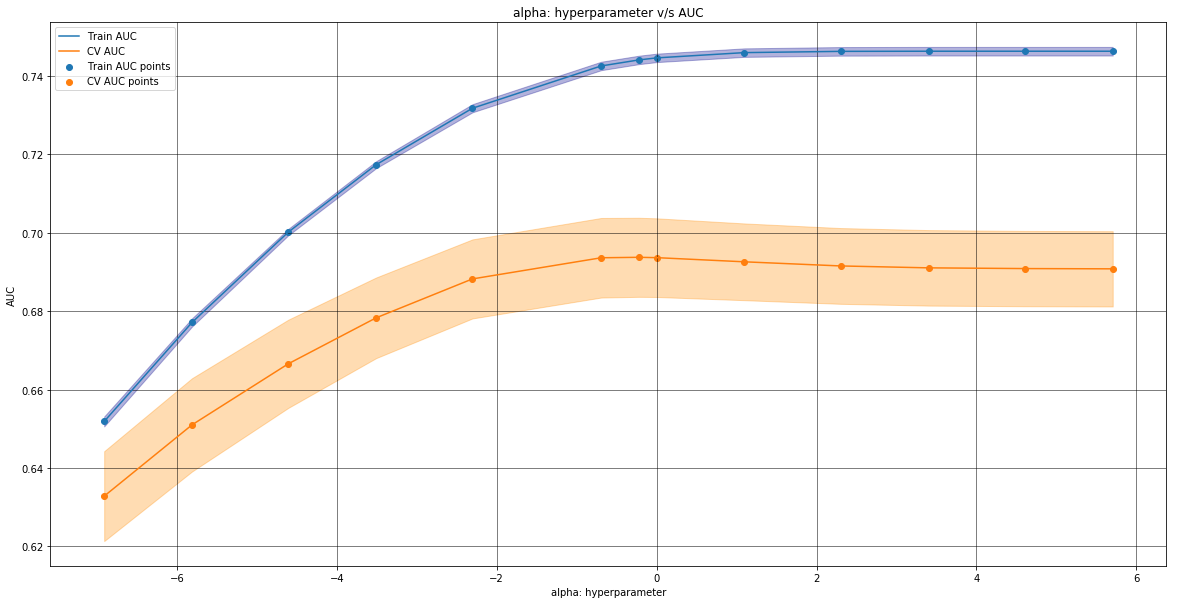

CPU times: user 36.1 s, sys: 624 ms, total: 36.7 s
Wall time: 53min 47s


In [134]:
%%time
#doing grid search to find best lambda
avgw2v_clf = doGridSearch(X_tr, y_train)

In [135]:
#randomizedsearchcv sklearn: https://www.youtube.com/watch?v=Gol_qOgRqfA
print(avgw2v_clf.best_score_)
print(avgw2v_clf.best_params_)

0.6937495643256804
{'C': 0.8}


In [136]:
print("Value of lambda is ",1/avgw2v_clf.best_params_['C'])

Value of lambda is  1.25


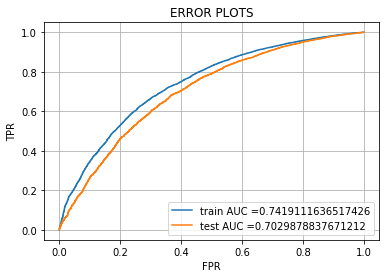

the maximum value of tpr*(1-fpr) 0.4665302455907214 for threshold 0.499
Train confusion matrix
[[ 3598  1570]
 [ 9346 18984]]
Test confusion matrix
[[1640  906]
 [4714 9240]]


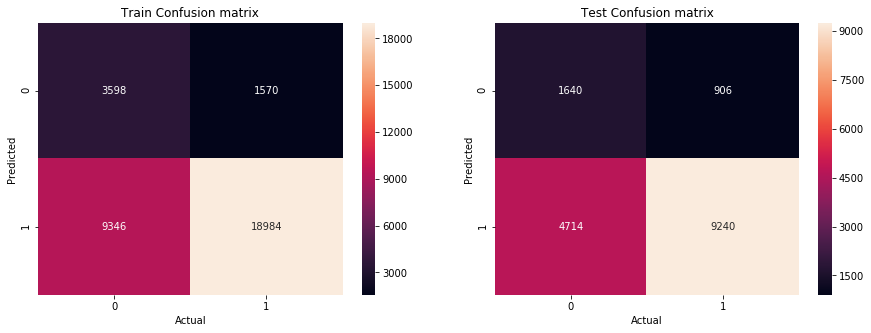

In [137]:
#plotting auc and confusion matrix
avgw2v_train_auc, avgw2v_test_auc = plotAucAndHeatmap(avgw2v_clf.best_params_['C'], X_tr, X_te, y_train, y_test)

### 2.4.1 Applying Logistic Regression on TFIDFW2V,<font color='red'> SET 4</font>

In [138]:
#creating train and test data for naive bayes on BOW
X_tr = hstack((price_train, quantity_train, previous_projects_train, catagories_train, sub_catagories_train, project_grade_train, state_train, teacher_prefix_train, tfidfw2v_essay_train, tfidfw2v_title_train)).tocsr()
X_te = hstack((price_test, quantity_test, previous_projects_test, catagories_test, sub_catagories_test, project_grade_test, state_test, teacher_prefix_test, tfidfw2v_essay_test, tfidfw2v_title_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33498, 702) (33498,)
(16500, 702) (16500,)


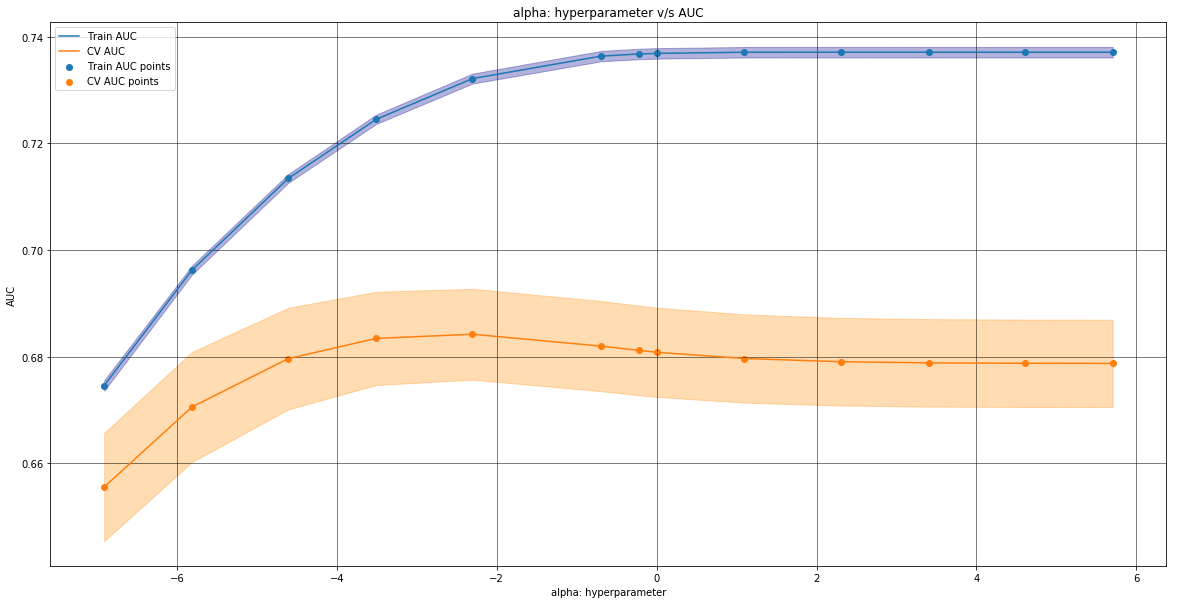

CPU times: user 18.3 s, sys: 546 ms, total: 18.9 s
Wall time: 44min 51s


In [139]:
%%time
#doing grid search to find best lambda
tfidfw2v_clf = doGridSearch(X_tr, y_train)

In [140]:
#randomizedsearchcv sklearn: https://www.youtube.com/watch?v=Gol_qOgRqfA
print(tfidfw2v_clf.best_score_)
print(tfidfw2v_clf.best_params_)

0.6841838698328158
{'C': 0.1}


In [141]:
print("Value of lambda is ",1/tfidfw2v_clf.best_params_['C'])

Value of lambda is  10.0


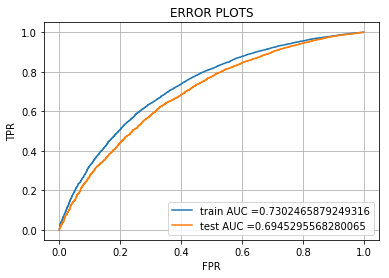

the maximum value of tpr*(1-fpr) 0.4501293769035658 for threshold 0.477
Train confusion matrix
[[ 3345  1823]
 [ 8628 19702]]
Test confusion matrix
[[1521 1025]
 [4391 9563]]


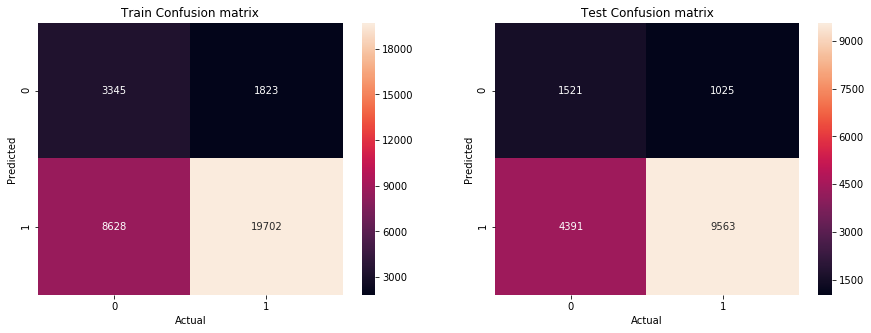

In [142]:
#plotting auc and confusion matrix
tfidfw2v_train_auc, tfidfw2v_test_auc = plotAucAndHeatmap(tfidfw2v_clf.best_params_['C'], X_tr, X_te, y_train, y_test)

<h2>2.5 Logistic Regression with added Features `Set 5` </h2>

In [143]:
#calculating various sentimence
train_negative_essay, train_neutral_essay, train_positive_essay, train_compound_essay = sentimenceOfEssay(essay_train)
test_negative_essay, test_neutral_essay, test_positive_essay, test_compound_essay = sentimenceOfEssay(essay_test)

100%|██████████| 16500/16500 [00:50<00:00, 327.72it/s]


In [144]:
#calculating word count
train_essay_word_count = countWords(essay_train)
train_title_word_count = countWords(title_train)
test_essay_word_count = countWords(essay_test)
test_title_word_count = countWords(title_test)

100%|██████████| 16500/16500 [00:00<00:00, 1078580.14it/s]


In [ ]:
#Normalizing the essay word count
count_vector = fitNumerical(pd.DataFrame(train_essay_word_count).values.reshape(-1,1))
train_essay_count = transformNumerical(pd.DataFrame(train_essay_word_count).values.reshape(-1,1), count_vector)
test_essay_count = transformNumerical(pd.DataFrame(test_essay_word_count).values.reshape(-1,1), count_vector)

In [ ]:
#Normalizing the title word count
count_vector = fitNumerical(pd.DataFrame(train_title_word_count).values.reshape(-1,1))
train_title_count = transformNumerical(pd.DataFrame(train_title_word_count).values.reshape(-1,1), count_vector)
test_title_count = transformNumerical(pd.DataFrame(test_title_word_count).values.reshape(-1,1), count_vector)

In [147]:
#creating train and test data for naive bayes on BOW
X_tr = hstack((price_train, quantity_train, previous_projects_train, catagories_train, sub_catagories_train, project_grade_train, state_train, teacher_prefix_train, train_negative_essay, train_neutral_essay, train_positive_essay, train_compound_essay, train_essay_count, train_title_count)).tocsr()
X_te = hstack((price_test, quantity_test, previous_projects_test, catagories_test, sub_catagories_test, project_grade_test, state_test, teacher_prefix_test, test_negative_essay, test_neutral_essay, test_positive_essay, test_compound_essay, test_essay_count, test_title_count)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33498, 108) (33498,)
(16500, 108) (16500,)


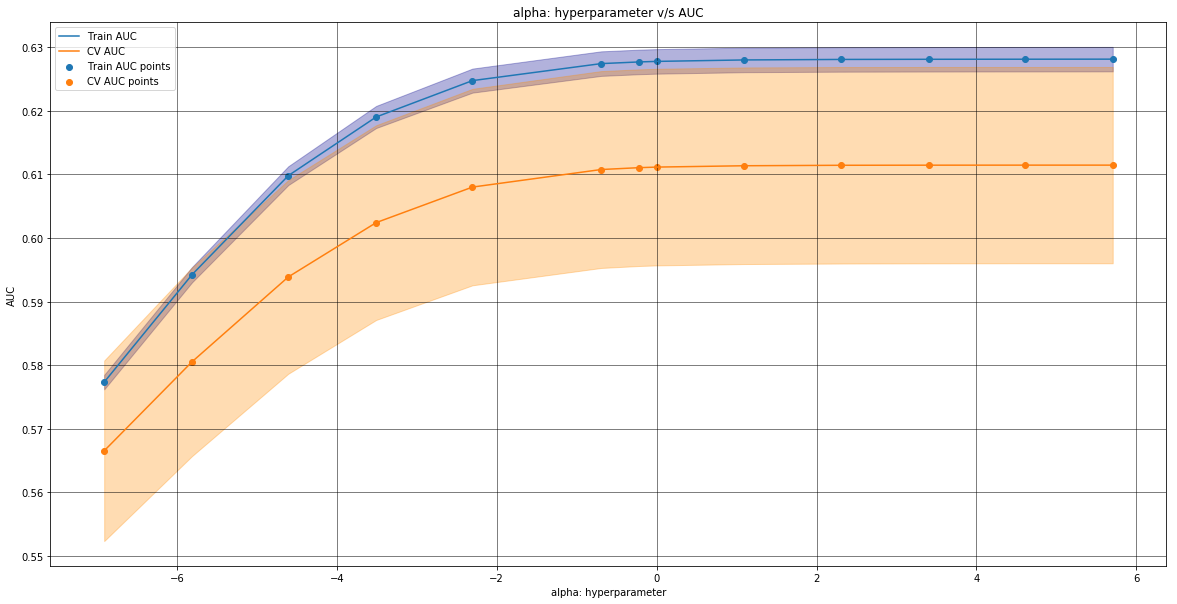

CPU times: user 2.09 s, sys: 298 ms, total: 2.39 s
Wall time: 36.6 s


In [148]:
%%time
#doing grid search to find best lambda
withoutText_clf = doGridSearch(X_tr, y_train)

In [149]:
#randomizedsearchcv sklearn: https://www.youtube.com/watch?v=Gol_qOgRqfA
print(withoutText_clf.best_score_)
print(withoutText_clf.best_params_)

0.6114651735094281
{'C': 300}


In [150]:
print("Value of lambda is ",1/withoutText_clf.best_params_['C'])

Value of lambda is  0.0033333333333333335


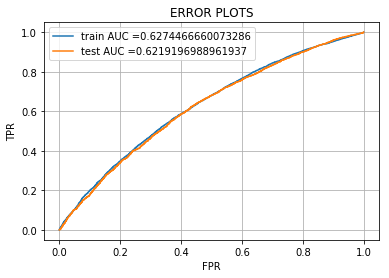

the maximum value of tpr*(1-fpr) 0.3534624543335456 for threshold 0.503
Train confusion matrix
[[ 3144  2024]
 [11870 16460]]
Test confusion matrix
[[1525 1021]
 [5774 8180]]


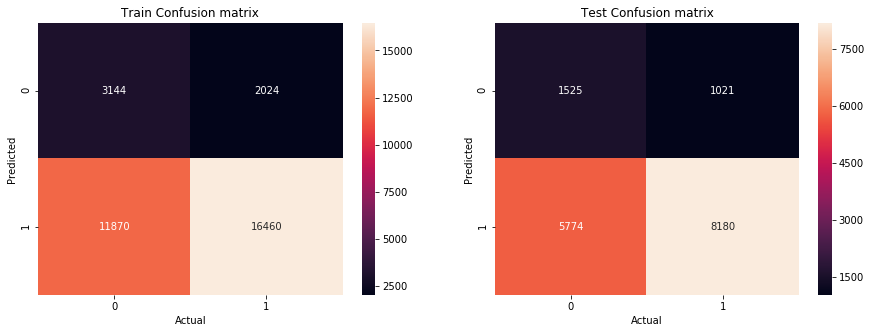

In [151]:
#plotting auc and confusion matrix
withoutText_train_auc, withoutText_test_auc = plotAucAndHeatmap(withoutText_clf.best_params_['C'], X_tr, X_te, y_train, y_test)

<h1>3. Conclusion</h1>

In [152]:
table = PrettyTable()
table.field_names = ["Vectorizer", "Hyper Parameter", "Train AUC", "Test AUC"]

table.add_row(["BOW", bow_clf.best_params_['C'], bow_train_auc, bow_test_auc])
table.add_row(["TFIDF", tfidf_clf.best_params_['C'],tfidf_train_auc, tfidf_test_auc])
table.add_row(["AVG_W2V", avgw2v_clf.best_params_['C'], avgw2v_train_auc, avgw2v_test_auc])
table.add_row(["TFIDF_W2V", tfidfw2v_clf.best_params_['C'], tfidfw2v_train_auc, tfidfw2v_test_auc])
table.add_row(["Without Text ", withoutText_clf.best_params_['C'], withoutText_train_auc, withoutText_test_auc])

print (table)

+---------------+-----------------+--------------------+--------------------+
|   Vectorizer  | Hyper Parameter |     Train AUC      |      Test AUC      |
+---------------+-----------------+--------------------+--------------------+
|      BOW      |      0.003      | 0.8096515771114212 | 0.7088877257009086 |
|     TFIDF     |       0.1       | 0.803578341669772  | 0.7034052015369545 |
|    AVG_W2V    |       0.8       | 0.7419111636517426 | 0.7029878837671212 |
|   TFIDF_W2V   |       0.1       | 0.7302465879249316 | 0.6945295568280065 |
| Without Text  |       300       | 0.6274466660073286 | 0.6219196988961937 |
+---------------+-----------------+--------------------+--------------------+
